# HW 5 - Page Rank
### Team 8: Yao Chen, Toby Petty, Ferdous Alam, Zixi Wang
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2021`__


In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions under which it will converge.
* ... __identify__ what modifications must be made to the web graph in order to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
# RUN THIS CELL AS IS. 
tot = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
for item in dbutils.fs.ls(DATA_PATH):
  tot = tot+item.size
tot
# ~4.7GB

Out[2]: 4751198766

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
sc = spark.sparkContext
spark

Out[4]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.0.128.15:7077 
 AppName 
 Databricks Shell

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concerns that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ For example, Facebook (meta) dataset would be appropriate to represent as a graph. Each user's Facebook profile is the node and his/her connections are the edges.This type of graph is 'undirected' since each pair of friendship connections are mutal relationships - both users know each other. This is a two-way connection, which can be different from Twitter where a follower connection is directed and doesn't need to be connected mutually. The average "in-degree" of a node will be the average number of connections for a single user profile.

> __b)__ The data structure of graphs require a large number of iterations to work with. However, a map-reduce paradigm is not suitable for iterative computing because it can only conduct one iteration. To implement an iterative algorithm, the programmer needs to explicitly handle the iteration. For example, after each iteration, the programmer needs to write the intermediate results into a specified location for the next iteration (another map-reduce procedure) to read. Therefore, implementing map-reduce paradigm is difficult on graphs because such implementation involves heavy I/O and extra job start up time, which is very inefficient.

> __c)__ Dijkstra's algorithm is an algorithm for finding the shortest paths from a single source node to all other nodes in a graph. Since this algorithm uses a data structure for storing and querying partial solutions sorted by distance from the source node by using a minimum priority queue, it is hard to parallelize as in Map-Reduce we cannot maintain the state of the min priority queue. For example, in the reducer phase, if distance to a node has gotten shorter, we need to recompute the shortest path for each node in the subgraph emanating from that node.

> __d)__ In order to parallelize using Breadth-First-Search, we need to put source node in frontier and go through each potential solution to find the shortest path, which can be computationally expensive. For each node, in the Map phase we need to emit a key value pair for each neighbor in the adjacency list; in the Reduce phase, we can then select the minimum value for keys which is the shortest distance.

# Question 2: Representing Graphs

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ The figure in 5.1 has 5 vertices and 9 edges.
Dense graphs are densely connected where the number of edges is usually `O(n^2)` n being the number of vertices.
For the example this not being the case, appears to be sparse. In the graph there are a lot of zeros in the matrix, meaning that there are few edges between the nodes. The denser the matrix, the more edges/connections we will see between the nodes in a graph, the fewer zeros there will be in the adjacency matrix, the more neighbors each node will have in the adjacency list.
From a storage perspective an adjacency matrix requires  `O(V^2)` space whereas an adjacency list requires `Θ(|V|+|E|)` space to store.
So for sparse graph using an adjacency matrix is wasteful from a space perspective but quering it will be faster than an adjacency list, it can be implemented in `O(|V|+|E|log|E|)` time.
If the graph is dense both representations will need a quadratic amount of space to store, therefore using the adjacency matrix for `O(1)` edge queries is the better option.

> __b)__ The given code for the toy graph is an example of a directed graph since it has edges with direction and there are values on both sides of the diagonal line of the matrix. 
The adjacency matrix will be different for a directed graph and undirected graph because for an undirected graph the matrix is symmetric i.e.: `a_i,j=a_j,i` for every pair `i,j`, or `A=A^T`. For a directed graph there is an edge from `i` to `j` but necessarily an edge from `j` to `i` which would imply that the adjacency matrix of an directed graph is will not necessarily be symmetric i.e `A<>A^T`.

In [0]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

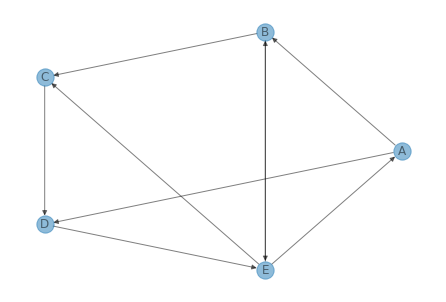

In [0]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for edge in graph['edges']:
      adj_matr.at[edge[0],edge[1]]=1
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

A B C D E
A 0 1 0 1 0
B 0 0 1 0 1
C 0 0 0 1 0
D 0 0 0 0 1
E 1 1 1 0 0

In [0]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for edge in graph['edges']:
      adj_list[edge[0]].append(edge[1])
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}

# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ In the analogy of an infinite web-surfer, the PageRank metric represents the frequency with which the surfer will visit a page relative to all others in the graph. It is a probability distribution over all the nodes in the graph (i.e. all the pages on the web), giving the likelihood that a random walk across the graph will arrive at a page. As PageRank algorithm reaches its steady state, the most important node (with highest frequency) will be the one that is the most likely for the web surfer to land on.

> __b)__ The Markov Property is a property of systems whereby the current state of the system gives all the relevant information required, meaning the full history of how the system arrived at the current state is not needed. An example would be a chess game, where the current state of the board (plus whose turn it is) is the only information required to analyse the game and decide the best next move; knowing the full history of how the game arrived in that state is not needed. In the context of the PageRank algorithm, the Markov Property means that on each iteration of the algorithm we only need to know the current PageRank values of each node in the graph in order to proceed with the next iteration of the algorithm; we don't need the full history of how the PageRank values have changed in all previous iterations.

> __c)__ In the context of PageRank, the $n$ states of the Markov Chain correspond to the individual webpages, which means that the transition matrix $P$ has dimensions $nxn$, where each entry $P_{ij}$ gives the probability of a surfer at a webpage denoted by row index $i$ transitioning to a webpage denoted by column index $j$. Given that the number of webpages is likely on the order of billions the implications are that this is an extremely large matrix.

> __d)__ The "right stochastic matrix" is the transition probability matrix in the Markov Chain which gives the probabilities of moving from each page in the index to each page in the columns. It must be a square matrix and each row in the matrix must sum to 1 to be a valid probability distribution.

> __e)__ When we run the `power_iteration` function for longer than 10 times we find that it eventually converges to the steady state probabilities after <b>52</b> iterations. The most central/highest ranked node is node <b>E</b>, which makes sense intuitively as it is the only node which is directly connected to all other nodes in the toy graph.

In [0]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

Out[11]:

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [0]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = TOY_ADJ_MATR.divide(TOY_ADJ_MATR.sum(axis = 1), axis = 0).fillna(0)
################ (END) YOUR CODE #################
print(transition_matrix)

A B C D E
A 0.000000 0.500000 0.000000 0.5 0.0
B 0.000000 0.000000 0.500000 0.0 0.5
C 0.000000 0.000000 0.000000 1.0 0.0
D 0.000000 0.000000 0.000000 0.0 1.0
E 0.333333 0.333333 0.333333 0.0 0.0

In [0]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing initial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    
    if verbose:
      print("|  ".join([s.ljust(12) for s in ["Iter"] + list(tMatrix.columns)]))

    state_vector = xInit.reshape(5,1)
    for i in range(nIter):
      state_vector = np.matmul(tMatrix.values.T, state_vector)

      if verbose:
        print("|  ".join([s.ljust(12) for s in [f"{i+1}"] + [f"{s[0].round(8)}" for s in state_vector]]))

    ################ (END) YOUR CODE #################
    return state_vector

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Iter | A | B | C | D | E 
1 | 0.0 | 0.5 | 0.0 | 0.5 | 0.0 
2 | 0.0 | 0.0 | 0.25 | 0.0 | 0.75 
3 | 0.25 | 0.25 | 0.25 | 0.25 | 0.0 
4 | 0.0 | 0.125 | 0.125 | 0.375 | 0.375 
5 | 0.125 | 0.125 | 0.1875 | 0.125 | 0.4375 
6 | 0.14583333 | 0.20833333 | 0.20833333 | 0.25 | 0.1875 
7 | 0.0625 | 0.13541667 | 0.16666667 | 0.28125 | 0.35416667 
8 | 0.11805556 | 0.14930556 | 0.18576389 | 0.19791667 | 0.34895833 
9 | 0.11631944 | 0.17534722 | 0.19097222 | 0.24479167 | 0.27256944 
10 | 0.09085648 | 0.1490162 | 0.17853009 | 0.24913194 | 0.33246528

In [0]:
steady_states = power_iteration(xInit, transition_matrix, 52, verbose = False)
steady_states

Out[15]: array([[0.10526316],
 [0.15789474],
 [0.18421053],
 [0.2368421 ],
 [0.31578947]])

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:
> __a)__ The state vector doesn't sum to 1 at later steps, which means the stochastic property is violated. Therefore, it is not converging. Node E is a "dangling node which only has incoming edges, therefore it is acting as sink for the mass being passed to it.

> __b)__ E is the dangling node in this graph. With a dangling node, there will be a row of all zeros in the transition matrix. Every time we apply the transition matrix, there will be a state probability equal to zero and thus the sum of state probability is not 1. To solve this, we can flip a biased coin. If it is head, we keep the calculated state vector; otherwise, we reset the state vector by redistributing the probability equally to each state.

> __c)__ Being irreducible means there is a path from every node to every other node. No, the webgraph isn't naturally irreducible by itself since a link is usually established if two pages are related. There are no links between irrelevant pages so it is not irreducible.

> __d)__ Being aperiodic means greatest common divisor of all cycle length is 1. Yes, in the case of webgraph, there will be some dangling nodes that have self-loops. Self-loop's cycle length is 1 and thus the greatest common divisor has to be 1. Therefore, webgraph is aperiodic.

> __e)__ Teleportation is introduced to ensure aperiodicity and irreducibility. In the case of a random surfer, it means there is a chance that the surfer will ignore the page rank algorithm and randomly choose any node in the graph as the next step. This is the ability to jump to any pages from any current page. The random surfer can transition to any new url from current website. PageRank can redistribute the probability mass from dangling pages to all the other pages.

In [0]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

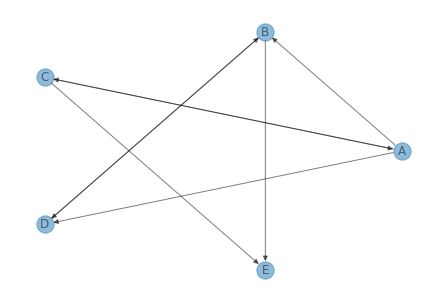

In [0]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
adj_matrix = get_adj_matr(TOY2_GRAPH)
trans_matrix = adj_matrix.divide(adj_matrix.sum(axis = 1), axis = 0).fillna(0)
power_iteration(xInit, trans_matrix, 10, verbose = True)
####### (END) YOUR CODE #################

Iter | A | B | C | D | E 
1 | 0.0 | 0.33333333 | 0.33333333 | 0.33333333 | 0.0 
2 | 0.16666667 | 0.33333333 | 0.0 | 0.16666667 | 0.33333333 
3 | 0.0 | 0.22222222 | 0.05555556 | 0.22222222 | 0.16666667 
4 | 0.02777778 | 0.22222222 | 0.0 | 0.11111111 | 0.13888889 
5 | 0.0 | 0.12037037 | 0.00925926 | 0.12037037 | 0.11111111 
6 | 0.00462963 | 0.12037037 | 0.0 | 0.06018519 | 0.06481481 
7 | 0.0 | 0.0617284 | 0.00154321 | 0.0617284 | 0.06018519 
8 | 0.0007716 | 0.0617284 | 0.0 | 0.0308642 | 0.0316358 
9 | 0.0 | 0.0311214 | 0.0002572 | 0.0311214 | 0.0308642 
10 | 0.0001286 | 0.0311214 | 0.0 | 0.0155607 | 0.0156893 
Out[18]: array([[0.0001286],
 [0.0311214],
 [0. ],
 [0.0155607],
 [0.0156893]])

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [0]:
dbutils.fs.ls(DATA_PATH)

Out[19]: [FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt', name='all-pages-indexed-in.txt', size=2143300687),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt', name='all-pages-indexed-out.txt', size=2090459616),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/indices.txt', name='indices.txt', size=517438296),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/test_graph.txt', name='test_graph.txt', size=167)]

In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

Out[22]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

Out[23]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

Out[24]: ["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The raw data is wiki pages represented as adjacency list in txt format. The first value is the node and the second part are the linked nodes (as keys) with the number of links to those pages (as values). Each record is a key-value pair where key is the wiki page ID (node) and value is a dictionary (adjacency list) showing the neighbors/linked page IDs along with weights. The weights can be interpreted as the number of times a page is linked/referenced in the source page.

> __b)__ The raw dataset file in txt format only contains non-dangling nodes. The dangling nodes don't have a linked page that are present in the adjacency list so they will have empty record of adjacency list. To get total number of nodes, we need to go through each node and get its linked node as well. Then we can find the total number by counting the number of distinct node ID.

> __d)__ The total number of dangling nodes are number of nodes minus number of records, since dangling nodes are in the adjacency list but do not have their own record. Therefore the calculation is 15,192,277 - 5,781,290 = 9,410,987 dangling nodes.

In [0]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290

In [0]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def get_nodes(line):
      node, adj_node = line.split('\t')
      adj_node = list(ast.literal_eval(adj_node).keys())      
      for n in adj_node + [node]:
        yield n
    totalCount = dataRDD.flatMap(get_nodes)\
                        .distinct()\
                        .count()
                        
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 1.282031536102295 seconds.
Total Nodes: 11

In [0]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 380.41759872436523 seconds.
Total Nodes: 15192277

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ In the context of the PageRank algorithm, for each node the PageRank probability mass needs to be distributed to its neighbour nodes in the adjacency list. Each node's out-degree is used to compute how much of the PageRank probability mass will need to be passed along to its outgoing edges.

> __c)__ If a node's out-degree is 0, that means this is a dangling node that doesn't have outgoing links to other nodes. It makes the graph "not nice" and reducible since the total probability mass will not be conserved. In the mapper phase, there would be no key-value pairs emitted for a dangling node. Therefore we will not see convergence to steady state probabilities among nodes. Noted the total PageRank values of all nodes should sum up to 1. In PageRank, we can redistribute the probability mass for dangling nodes among all nodes evenly. Whenever the mapper encounters a node with an empty adjacency list, we can use a counter to keep track of the dangling node's PageRank value (probability mass). At the end of the iterations, we can check the counter to figure out the lost of probability mass due to dangling nodes and then redistribute it to all nodes.

In [0]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    top, avgDegree, sampledCounts = None, None, None
    cachedRDD = dataRDD.map(parse)\
                       .mapValues(lambda x: len(x))\
                       .cache()
    top = cachedRDD.takeOrdered(10, key=lambda x:-x[1])
    cached_RDD_new = cachedRDD.map(lambda x : x[1]).cache()
    avgDegree = cached_RDD_new.mean()
    sampledCounts = cached_RDD_new.takeSample(False, n)
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [0]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 45.466562271118164 seconds
Average out-degree: 1.7
Top 10 nodes (by out-degree:)
 [('5', 3), ('4', 2), ('6', 2), ('7', 2), ('8', 2), ('9', 2), ('2', 1), ('3', 1), ('10', 1), ('11', 1)]

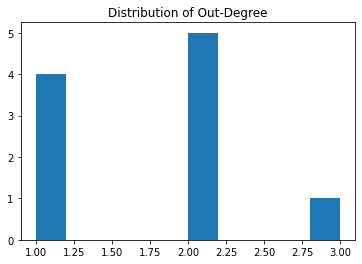

In [0]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 305.4659888744354 seconds
Average out-degree: 24.58172086160741
Top 10 nodes (by out-degree:)
 [('7883280', 7132), ('7884831', 5877), ('6075450', 5875), ('6074992', 5855), ('7828359', 5839), ('7880980', 5692), ('1008643', 5598), ('7828391', 5597), ('7873008', 5573), ('7841582', 5530)]

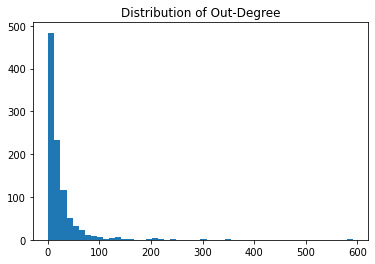

In [0]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q7 Tasks:
* __a) short response:__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ $N$ is the total number of nodes, i.e. number of pages in the graph that a random web-surfer would be traversing. In our case of Wiki page, N is 15,192,277. We initialize each node's rank to $$\frac{1}{N}$$ so that each page has an equal probability of being the first page in the "random surf"; it is a uniform probability distribution across all pages.

> __b)__ It will be more efficient to compute $N$ _after_ initializing records for each dangling node, otherwise $N$ would not be accurate as it would need to be updated to include the number of dangling nodes along with non-dangling nodes.

In [0]:
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############    
    # write any helper functions here
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    def iterate_edges(k_v):
      """Loops through all nodes linked to a node and yields the node ID
      and an empty dict. Also yields the original graph structure."""
      key, value = k_v
      yield key, value
      for node_id, weight in value.items():
        yield node_id, dict()
    
    # write your main Spark code here    
    graphRDD = dataRDD.map(parse)\
                      .flatMap(iterate_edges)\
                      .reduceByKey(lambda k1, k2: {**k1, **k2})  # Combine all linked node dicts.
    N = graphRDD.count()
    graphRDD = graphRDD.map(lambda k_v: (k_v[0], (1/N, k_v[1])))  # Initialize all nodes as 1/N.
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 13.865676403045654 seconds.
Out[35]: [('4', (0.09090909090909091, {'1': 1, '2': 1})),
 ('1', (0.09090909090909091, {})),
 ('8', (0.09090909090909091, {'2': 1, '5': 1})),
 ('9', (0.09090909090909091, {'2': 1, '5': 1})),
 ('10', (0.09090909090909091, {'5': 1})),
 ('2', (0.09090909090909091, {'3': 1})),
 ('3', (0.09090909090909091, {'2': 2})),
 ('5', (0.09090909090909091, {'4': 3, '2': 1, '6': 1})),
 ('6', (0.09090909090909091, {'2': 1, '5': 2})),
 ('7', (0.09090909090909091, {'2': 1, '5': 1})),
 ('11', (0.09090909090909091, {'5': 2}))]

In [0]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 995.3201193809509 seconds

In [0]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('11845481', (6.582291778908455e-08, {'2091682': 1, '10876462': 1, '2614581': 1, '13043447': 1, '951837': 1, '729116': 1, '12552466': 2, '6060165': 1, '729103': 2, '3733160': 1, '6061226': 1, '12552467': 2, '619248': 3, '10566067': 1, '9446348': 1, '6018175': 1, '3069084': 2, '1302732': 1}))]
... initialization continued: 266.6999809741974 seconds

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $$\alpha * \frac{1}{|G|}$$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies teleportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ The random jump factor `α` is sometimes called the “teleportation” factor. The teleport operation is defined as where a surfer jumps from a node to any other node in the web graph. This may happen if an address is typed into the URL bar of his browser. The destination of a teleport operation is modeled as being chosen uniformly at random from all web pages. In other words, if `N` is the total number of nodes in the web graph, the teleport operation takes the surfer to each node with probability `1/N` (chances of landing at any particular page). The surfer would also teleport to his present position with probability `1/N`. Since there is an `1/|G|` chance of landing at any particular page, where |G| is the number of nodes in the web-graph, with probablity alpha `α` (a.k.a teleportationi factor), the entire probablity of random jump to a particular page is `α * 1/|G|`.

> __b)__ `m` is the missing PageRank mass lost at the dangling nodes, and `|G|` is the number of nodes in the entire graph. we divide `m`  by `|G|` to calculate share of the lost PageRank mass that is redistributed to each node in the graph.

> __c)__ For the iterative algorithm to work we need to have the exact the same data structure as the beginning, after each iteration.  PageRank itself is a probability distribution which is spreading probability mass to neighbors via outgoing links. Therefore PageRank values of all nodes or the total probabilty mass should sum up to 1 after each iteration.

In [0]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We strongly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
    
    # Calculate number of nodes for dividing teleportation factor:
    N = sc.broadcast(graphInitRDD.count())
    teleportation_mass = sc.broadcast(a.value / N.value)
    
    def map_non_dangling_mass(record):
      """Emit the weights for non-dangling nodes, along with 
      the original graph structure for the next iteration."""
      node_id, (mass, neighbors) = record
      edge_count = sum(neighbors.values())
      
      # Pass through the original graph structure with zero mass:
      yield node_id, (0, neighbors)
       
      # Iterate each edge with its share of the redistributed mass:
      if edge_count:
        mass_div_edge_count = mass / edge_count
        for n_id, weight in neighbors.items():
          neighbor_mass = mass_div_edge_count * weight
          yield n_id, (neighbor_mass, dict())

    def reducer(x, y):
      """Sum weights and combine dictionaries of edges."""
      x_mass, x_neighbors = x[0], x[1]
      y_mass, y_neighbors = y[0], y[1]
      total_mass = x_mass + y_mass
      all_neighbors = {**x_neighbors, **y_neighbors}
      return (total_mass, all_neighbors)
    
    def add_dangling_mass(record):
      """Add the constant dangling mass to all nodes."""
      node_id, (mass, neighbors) = record
      return node_id, (mass + dangling_mass_to_add.value, neighbors)
    
    def apply_teleportation(record):
      """Apply the 'teleportation' scaling factor alpha."""
      node_id, (mass, neighbors) = record
      mass *= d.value
      mass += teleportation_mass.value
      return node_id, (mass, neighbors)
            
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    if verbose:
      print("|  ".join([c.ljust(15) for c in ("Iter", "Total Mass", "Dangling Mass")]))

    prev_iter_rdd = graphInitRDD
    for iteration in range(1, maxIter+1, 1):
      
      # Calculate total dangling node mass:
      mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
      prev_iter_rdd.filter(lambda x: not len(x[1][1])).foreach(lambda x: mmAccum.add(x[1][0]))
      dangling_mass_to_add = sc.broadcast(mmAccum.value / N.value)
            
      # Apply PageRank:
      steadyStateRDD = prev_iter_rdd.flatMap(map_non_dangling_mass)\
                                    .reduceByKey(reducer)\
                                    .map(add_dangling_mass)\
                                    .map(apply_teleportation)\
                                    .cache()
      
      # Confirm the total mass after each iteration still sums to 1:
      totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
      steadyStateRDD.foreach(lambda x: totAccum.add(x[1][0]))
      
      if verbose:
        print("|  ".join([i.ljust(15) for i in (f"{iteration}", f"{totAccum.value:.9f}", f"{mmAccum.value:.9f}")]))
      
      prev_iter_rdd = steadyStateRDD
    
    # Just yield the page ranks without the full graph:
    steadyStateRDD = steadyStateRDD.map(lambda k_v: (k_v[0], k_v[1][0]))
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

Iter | Total Mass | Dangling Mass 
1 | 1.000000000 | 0.090909091 
2 | 1.000000000 | 0.059297521 
3 | 1.000000000 | 0.046703982 
4 | 1.000000000 | 0.099253384 
5 | 1.000000000 | 0.050342918 
6 | 1.000000000 | 0.051459165 
7 | 1.000000000 | 0.045009224 
8 | 1.000000000 | 0.047150825 
9 | 1.000000000 | 0.043746954 
10 | 1.000000000 | 0.043763235 
11 | 1.000000000 | 0.042982530 
12 | 1.000000000 | 0.043012895 
13 | 1.000000000 | 0.042723401 
14 | 1.000000000 | 0.042698603 
15 | 1.000000000 | 0.042615733 
16 | 1.000000000 | 0.042605138 
17 | 1.000000000 | 0.042577127 
18 | 1.000000000 | 0.042571431 
19 | 1.000000000 | 0.042562620 
20 | 1.000000000 | 0.042560348 
...trained 20 iterations in 295.1338918209076 seconds.
Top 20 ranked nodes:
Out[40]: [('2', 0.3620640495978871),
 ('3', 0.333992700474142),
 ('5', 0.08506399429624555),
 ('4', 0.06030963508473455),
 ('1', 0.04255740809817991),
 ('6', 0.03138662354831139),
 ('8', 0.01692511778009981),
 ('9', 0.01692511778009981),
 ('10', 0.01692511778009981),
 ('7', 0.01692511778009981),
 ('11', 0.01692511778009981)]

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [0]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

Iter | Total Mass | Dangling Mass 
1 | 1.000000000 | 0.619458624 
2 | 1.000000000 | 0.496236655 
3 | 1.000000000 | 0.458458966 
4 | 1.000000000 | 0.445186246 
5 | 1.000000000 | 0.440201478 
6 | 1.000000000 | 0.438184121 
7 | 1.000000000 | 0.437326762 
8 | 1.000000000 | 0.436945158 
9 | 1.000000000 | 0.436768490 
10 | 1.000000000 | 0.436683430 
...trained 10 iterations in 10352.27864575386 seconds.
Top 20 ranked nodes:
Out[41]: [('13455888', 0.0015447247129693742),
 ('4695850', 0.0006710240718848024),
 ('5051368', 0.0005983856809695418),
 ('1184351', 0.0005982073536424869),
 ('2437837', 0.0004624928928899022),
 ('6076759', 0.00045509400641061083),
 ('4196067', 0.00044237788883337315),
 ('13425865', 0.0004415535171391651),
 ('6172466', 0.00042240020018091386),
 ('1384888', 0.0004012895604045913),
 ('6113490', 0.0003957892477153096),
 ('14112583', 0.0003943847283716329),
 ('7902219', 0.0003700987847324776),
 ('10390714', 0.00036502649642948217),
 ('12836211', 0.00036199488630751585),
 ('6237129', 0.00035195558475935605),
 ('6416278', 0.0003486623564496288),
 ('13432150', 0.00033936510637098125),
 ('1516699', 0.00033297500285946706),
 ('7990491', 0.00030760906265573924)]

In [0]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
top_20

Out[43]: [('13455888', 0.0015447247129693742),
 ('4695850', 0.0006710240718848024),
 ('5051368', 0.0005983856809695418),
 ('1184351', 0.0005982073536424869),
 ('2437837', 0.0004624928928899022),
 ('6076759', 0.00045509400641061083),
 ('4196067', 0.00044237788883337315),
 ('13425865', 0.0004415535171391651),
 ('6172466', 0.00042240020018091386),
 ('1384888', 0.0004012895604045913),
 ('6113490', 0.0003957892477153096),
 ('14112583', 0.0003943847283716329),
 ('7902219', 0.0003700987847324776),
 ('10390714', 0.00036502649642948217),
 ('12836211', 0.00036199488630751585),
 ('6237129', 0.00035195558475935605),
 ('6416278', 0.0003486623564496288),
 ('13432150', 0.00033936510637098125),
 ('1516699', 0.00033297500285946706),
 ('7990491', 0.00030760906265573924)]

__`expected results for the full graph:`__
```
top_20 = 
[(13455888, 0.0015447247129832947),
 (4695850, 0.0006710240718906518),
 (5051368, 0.0005983856809747697),
 (1184351, 0.0005982073536467391),
 (2437837, 0.0004624928928940748),
 (6076759, 0.00045509400641448284),
 (4196067, 0.0004423778888372447),
 (13425865, 0.00044155351714348035),
 (6172466, 0.0004224002001845032),
 (1384888, 0.0004012895604073632),
 (6113490, 0.00039578924771805474),
 (14112583, 0.0003943847283754762),
 (7902219, 0.000370098784735699),
 (10390714, 0.0003650264964328283),
 (12836211, 0.0003619948863114985),
 (6237129, 0.0003519555847625285),
 (6416278, 0.00034866235645266493),
 (13432150, 0.00033936510637418247),
 (1516699, 0.00033297500286244265),
 (7990491, 0.00030760906265869104)]
```

In [0]:
# Save the top_20 results to disc for use later. So you don't have to rerun everything if you restart the cluster.

# Created a directory under dbfs
dbutils.fs.mkdirs("/team8_temp")

# Convert to dataframe
top_20_df = pd.DataFrame(top_20)

# Save to dbfs temp folder
top_20_df.to_csv('/dbfs/team8_temp/team8_top_20.csv')

In [0]:
temp_path = "/team8_temp"
# read Top_20 results csv from dbfs
top20 = spark.read.csv((f"{temp_path}"))
display(top20)

_c0,_c1,_c2
null,0,1
0,13455888,0.0015447247129693742
1,4695850,0.0006710240718848024
2,5051368,0.0005983856809695418
3,1184351,0.0005982073536424869
4,2437837,0.0004624928928899022
5,6076759,0.00045509400641061083
6,4196067,0.00044237788883337315
7,13425865,0.0004415535171391651
8,6172466,0.00042240020018091386


In [0]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

Out[46]: ['! $var = &quot;&quot;\t1\t1\t0']

In [0]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

Out[48]: [(1, '! $var = &quot;&quot;'), (2, '! (CONFIG.SYS directive)')]

# OPTIONAL
### The rest of this notebook is optional and doesn't count toward your grade.
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

## Join with indexRDD and print pretty

In [0]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############

############## END YOUR CODE ###############

In [0]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

PageRank | Page id | Title
====================================================================================================

--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-2661063350705224> in <module> 
 3 print ( "{:10s}\t| {:10s}\t| {}" . format ( "PageRank" , "Page id" , "Title" ) ) 
 4 print ( "=" * 100 ) 
 ----> 5 for r in joinedWithNames : 
 6 print ( "{:6f}\t| {:10d}\t| {}" . format ( r [ 1 ] [ 1 ] , r [ 0 ] , r [ 1 ] [ 0 ] ) ) 

 TypeError : 'NoneType' object is not iterable

## OPTIONAL - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

### You will need to generate vertices (v) and edges (e) to feed into the graph below. 
Use as many cells as you need for this task.

In [0]:
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)


In [0]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [0]:
start = time.time()
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)
print(f'... completed job in {time.time() - start} seconds.')

In [0]:
%%time
top_20.show()

### Run the cells below to join the results of the graphframes pagerank algorithm with the names of the nodes.

In [0]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
namesKV_DF = namesKV_RDD.toDF()

In [0]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [0]:
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [0]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform